In [1]:
import pandas as pd
import os
import glob

import matplotlib.pyplot as plt

In [2]:
folder_path = 'train_data'
csv_files = glob.glob(os.path.join(folder_path, 'query*.csv'))


In [3]:

df_list = []

for file in csv_files:
    df = pd.read_csv(file)
    df_list.append(df)

merged_df = pd.concat(df_list, ignore_index=True)
merged_df

,caption,id,valid
0,a women with umbrella,train_data/videos/VIRAT_S_010200_04_000568_000...,1
1,a women with umbrella,train_data/videos/VIRAT_S_010200_04_000568_000...,1
2,a women with umbrella,train_data/videos/VIRAT_S_010200_04_000568_000...,1
3,a women with umbrella,train_data/videos/VIRAT_S_010200_04_000568_000...,1
4,a women with umbrella,train_data/videos/VIRAT_S_010201_01_000125_000...,0
...,...,...,...
346,a person carrying a cabin bag,train_data/videos/VIRAT_S_010201_01_000125_000...,0
347,a person carrying a cabin bag,train_data/videos/VIRAT_S_010201_01_000125_000...,0
348,a person carrying a cabin bag,train_data/videos/VIRAT_S_010201_01_000125_000...,0
349,a person carrying a cabin bag,train_data/videos/VIRAT_S_010201_01_000125_000...,0


In [4]:
data_list = []

grouped = merged_df.groupby(['caption'])

for caption, group in grouped:
    #print(caption , group)
    positive_images = group[group['valid'] == 1]['id'].tolist()
    negative_images = group[group['valid'] == 0]['id'].tolist()

    data_list.append({
        "caption": caption,
        "positive_images": positive_images,
        "negative_images": negative_images
    })


In [5]:
print(f"length of data list {len(data_list)}")
data_list

length of data list 12


[{'caption': ('a boy wearing red converse shoes',),
  'positive_images': ['train_data/videos/VIRAT_S_010200_07_000748_000837.mp4_470_22.png',
   'train_data/videos/VIRAT_S_010200_07_000748_000837.mp4_490_22.png',
   'train_data/videos/VIRAT_S_010200_07_000748_000837.mp4_650_33.png',
   'train_data/videos/VIRAT_S_010200_07_000748_000837.mp4_660_33.png',
   'train_data/videos/VIRAT_S_010200_07_000748_000837.mp4_670_33.png',
   'train_data/videos/VIRAT_S_010200_07_000748_000837.mp4_680_33.png',
   'train_data/videos/VIRAT_S_010200_07_000748_000837.mp4_690_33.png'],
  'negative_images': ['train_data/videos/VIRAT_S_010200_07_000748_000837.mp4_420_33.png',
   'train_data/videos/VIRAT_S_010200_07_000748_000837.mp4_430_33.png',
   'train_data/videos/VIRAT_S_010200_07_000748_000837.mp4_1110_33.png',
   'train_data/videos/VIRAT_S_010200_07_000748_000837.mp4_1150_23.png',
   'train_data/videos/VIRAT_S_010200_07_000748_000837.mp4_1180_23.png',
   'train_data/videos/VIRAT_S_010200_07_000748_000837.

In [6]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import random
from transformers import CLIPTokenizer , CLIPImageProcessor , CLIPModel , CLIPProcessor
from torch.utils.data import DataLoader
import torch.nn.functional as F

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
text_processor = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
image_processor = CLIPImageProcessor.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


/Users/shubby/Desktop/UB/Sem2/DeepLearning/Project/vsearch/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [7]:
class ClipHardNegativeDataset(Dataset):
    def __init__(self, data_list, tokenizer, image_transform=None):
        self.data = data_list
        self.tokenizer = tokenizer
        self.transform = image_transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.4815, 0.4578, 0.4082),
                                 std=(0.2686, 0.2613, 0.2758))
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        caption = item['caption']
        pos_images = item['positive_images']
        neg_images = item['negative_images']

        
        image_paths = pos_images + neg_images
        image_tensors = []
        for img_path in image_paths:
            img = Image.open(img_path).convert("RGB")
            image_tensors.append(self.transform(img))

        images = torch.stack(image_tensors)  # Shape: [N, 3, H, W]
        labels = torch.ones(images.shape[0])
        labels[len(pos_images):] = 0

        text_tokens = self.tokenizer(caption, return_tensors="pt", padding=True, truncation=True)

        return text_tokens, images, labels



In [8]:

def eval_hard_negatives(model, data_list, image_dir, processor):
    model.eval()
    total = len(data_list)
    correct_at_k = 0

    recall_list = []
    with torch.no_grad():
        for entry in data_list:
            caption = entry["caption"]
            pos_imgs = entry["positive_images"]
            neg_imgs = entry["negative_images"]
            all_imgs = pos_imgs + neg_imgs
            image_embeddings = []
            image_names = []

            for img_name in all_imgs:
                img_path = os.path.join(image_dir, img_name)
                image = Image.open(img_path).convert("RGB")
                inputs = processor(images=image, return_tensors="pt")
                img_emb = model.get_image_features(**inputs)
                image_embeddings.append(img_emb)
                image_names.append(img_name)

            image_embeddings = torch.cat(image_embeddings) 
            
            inputs = processor(text=caption, return_tensors="pt", padding=True, truncation=True)
            text_emb = model.get_text_features(**inputs) 
            sims = F.cosine_similarity(text_emb, image_embeddings) 
            #print(sims)
            top_k_names = []
            for i , score in enumerate(sims):
                if score > -0.5:
                    top_k_names.append(image_names[i])
            

            #  positive top-ks
            count = 0 
            for name in top_k_names:
                if name in pos_imgs:
                    count += 1
            
            recall = count/len(top_k_names) if len(top_k_names) != 0 else 0 
            recall_list.append(recall)
            #print(recall)

    avg_recall = sum(recall_list)/len(recall_list)
    return avg_recall

image_dir = ""

print("Train recall initally " , eval_hard_negatives(model, data_list[:10], image_dir, processor))
print("Test recall initally " , eval_hard_negatives(model, data_list[10:], image_dir, processor))

Train recall initally  0.1470242656449553
Test recall initally  0.06666666666666667


In [9]:
dataset = ClipHardNegativeDataset(data_list, text_processor)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [10]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-6)
loss_list = []
train_recall_list = []
test_recall_list = []
epochs = 100

In [11]:

for i in range(epochs):
    curr_loss = 0.0
    for batch in loader:
        
        text_tokens, images, labels = batch
        
        B, N, C, H, W = images.shape
        images = images.view(B * N, C, H, W)
        
        input_ids = text_tokens["input_ids"].squeeze(1)    # [B, T]
        attention_mask = text_tokens["attention_mask"].squeeze(1)
        
        text_features = model.get_text_features(input_ids=input_ids, attention_mask=attention_mask)  # [B, D]
        text_features = F.normalize(text_features, dim=-1)
        #print(text_features.shape)
        
        image_features = model.get_image_features(images)               # [B*N, D]
        image_features = image_features.view(B, N, -1)                  # [B, N, D]
        image_features = F.normalize(image_features, dim=-1)
        
        logits = torch.einsum("bd,bnd->bn", text_features, image_features)
        #print(image_features.shape)
        #print(labels)
        #print(logits)
        
        loss = F.cross_entropy(logits, labels)
        
        curr_loss += loss.item()
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    

    train_recall = eval_hard_negatives(model, data_list[:10], image_dir, processor)
    test_recall = eval_hard_negatives(model, data_list[10:], image_dir, processor)
    
    loss_list.append(curr_loss)
    train_recall_list.append(train_recall)
    test_recall_list.append(test_recall)
    
    print(f"Episode {i+1} , Curr Loss : {curr_loss} , train_recall : {train_recall} , test_recall : {test_recall}")

Episode 1 , Curr Loss : 157.6152858734131 , train_recall : 0.1470242656449553 , test_recall : 0.06666666666666667
Episode 2 , Curr Loss : 150.65531730651855 , train_recall : 0.1470242656449553 , test_recall : 0.06666666666666667
Episode 3 , Curr Loss : 142.68159198760986 , train_recall : 0.1470242656449553 , test_recall : 0.06666666666666667
Episode 4 , Curr Loss : 135.81087684631348 , train_recall : 0.18124332570556828 , test_recall : 0.06666666666666667
Episode 5 , Curr Loss : 132.12928771972656 , train_recall : 0.3095141700404858 , test_recall : 0.13636363636363635
Episode 6 , Curr Loss : 128.28889894485474 , train_recall : 0.3356267507002801 , test_recall : 0.1875
Episode 7 , Curr Loss : 125.4020128250122 , train_recall : 0.3889724310776942 , test_recall : 0.2222222222222222
Episode 8 , Curr Loss : 122.49135494232178 , train_recall : 0.4072128851540616 , test_recall : 0.375
Episode 9 , Curr Loss : 121.21865606307983 , train_recall : 0.37337719298245614 , test_recall : 0.4
Episode 1

In [12]:
save_path = "./clip-hard-neg-model-fine_tune"

model.save_pretrained(save_path)
processor.save_pretrained(save_path)
text_processor.save_pretrained(save_path)
image_processor.save_pretrained(save_path)

['./clip-hard-neg-model-fine_tune/preprocessor_config.json']

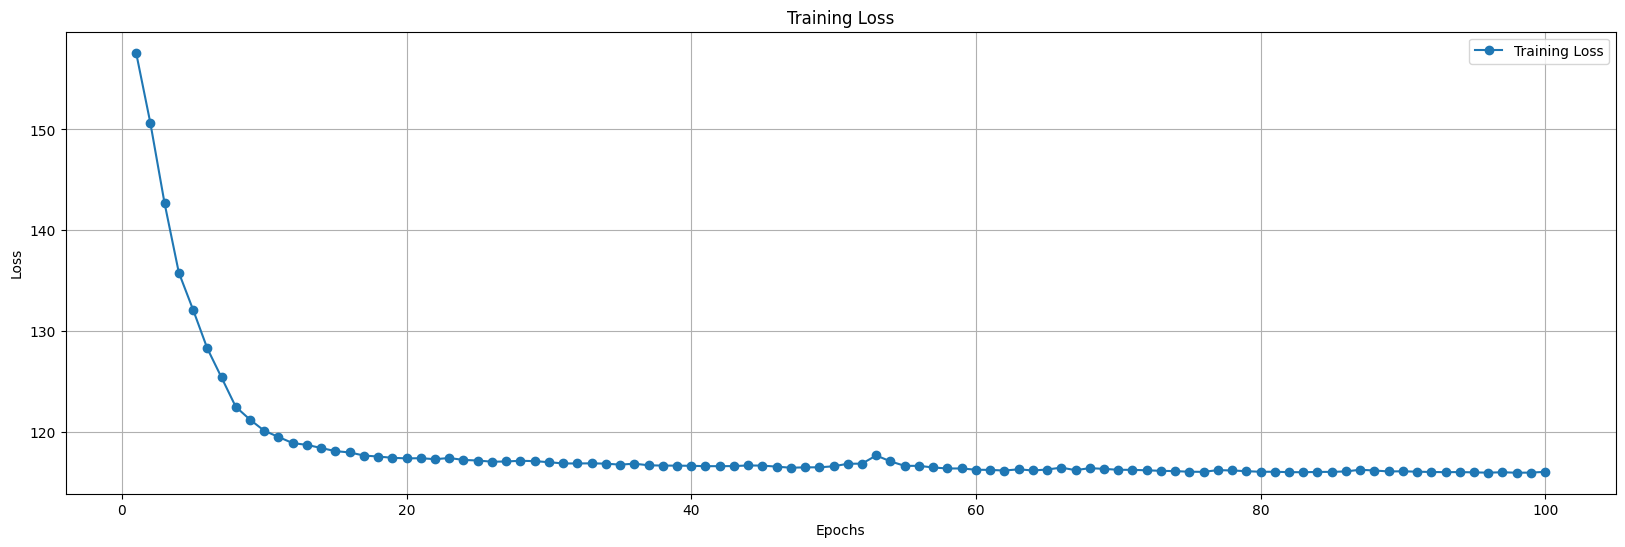

In [13]:


plt.figure(figsize=(20, 6))
epochs = range(1, len(loss_list) + 1)

plt.plot(epochs, loss_list, label='Training Loss', marker='o')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.grid()
plt.xticks()
plt.show()
plt.show()

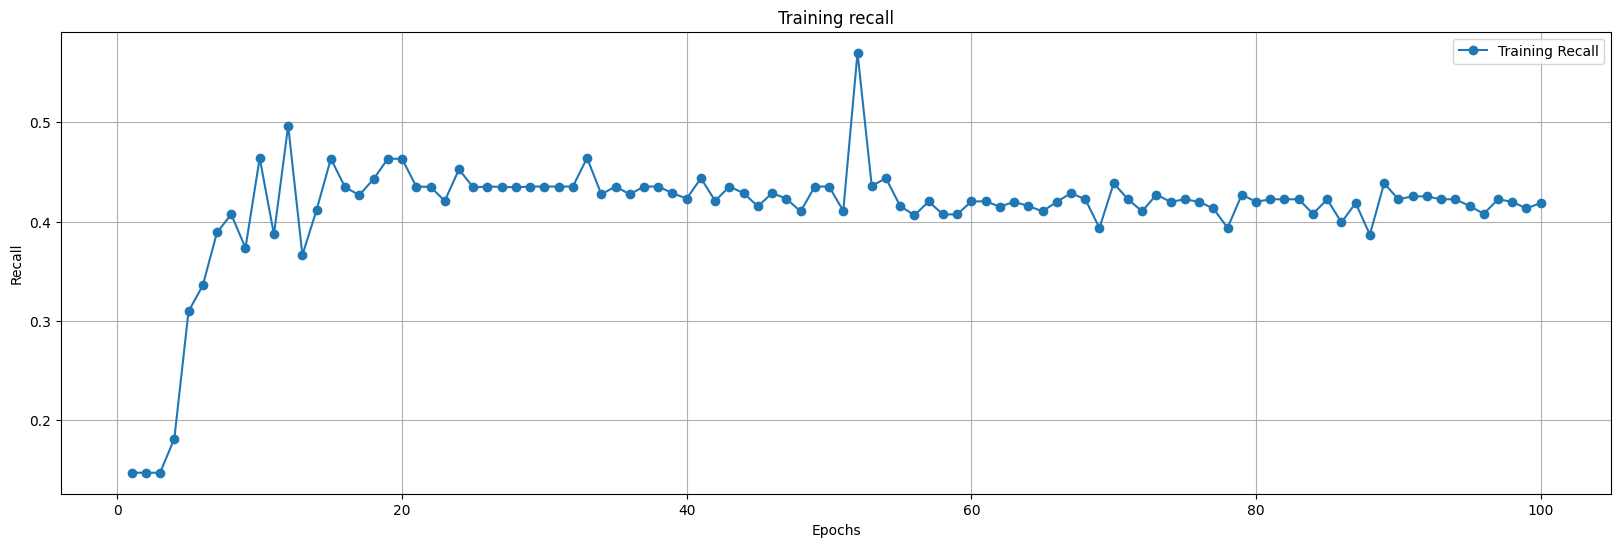

In [14]:
plt.figure(figsize=(20, 6))
epochs = range(1, len(train_recall_list) + 1)

plt.plot(epochs, train_recall_list, label='Training Recall', marker='o')
plt.title('Training recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')

plt.legend()
plt.grid()
plt.xticks()
plt.show()
plt.show()

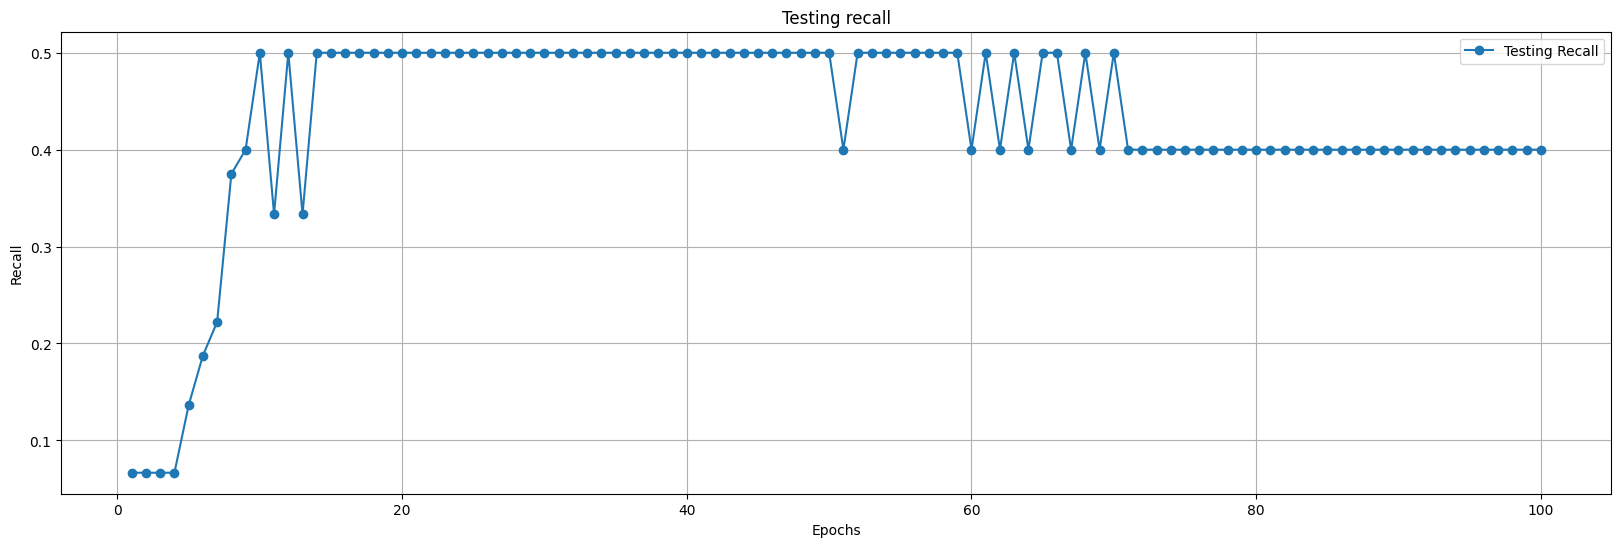

In [16]:
plt.figure(figsize=(20, 6))
epochs = range(1, len(test_recall_list) + 1)

plt.plot(epochs, test_recall_list, label='Testing Recall', marker='o')
plt.title('Testing recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')

plt.legend()
plt.grid()
plt.xticks()
plt.show()
plt.show()